<a href="https://colab.research.google.com/github/dpk-a7/Deep-learning/blob/main/lstm_toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json# For competition datasets
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

--2021-07-12 14:47:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-12 14:47:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-12 14:47:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
!unzip glove.6B.zip
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [4]:
MAX_SEQ_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [5]:
#loading word vectors..
word2vec = {} #key = word: value = vectors
with open(os.path.join("glove.6B.%sd.txt" % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype= 'float32')
    word2vec[word] = vec
print("found %s word vectors" % len(word2vec))

found 400000 word vectors


In [6]:
word2vec['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [7]:
#Loading comments
train = pd.read_csv("train.csv")
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [8]:
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ['toxic', 'severe_toxic', 'obscene',
                   'threat','insult', 'identity_hate']
targets = train[possible_labels].values

In [9]:
print("max sequence length:",max(len(s)for s in sentences))
print("min sequence length:",min(len(s)for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s)//2])

max sequence length: 5000
min sequence length: 6
median sequence length: 205


In [10]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [11]:
word2idx = tokenizer.word_index
print("found %s unique tokens" % len(word2idx))

found 210337 unique tokens


In [12]:
data = pad_sequences(sequences, maxlen = MAX_SEQ_LENGTH)
print("Shape of data tensor:", data.shape)

Shape of data tensor: (159571, 100)


In [13]:
print("Filling pre-trained embeddings..")
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings..


In [14]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQ_LENGTH,
    trainable = False
)

In [18]:
# model build
input_ = Input(shape=(MAX_SEQ_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)
model = Model(input_, output)
model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [19]:
# Training model
r = model.fit(
    data,
    targets,
    batch_size = BATCH_SIZE,
    epochs= EPOCHS,
    validation_split = VALIDATION_SPLIT
)

Epoch 1/10
998/998 [==============================] - 73s 55ms/step - loss: 0.1086 - accuracy: 0.8811 - val_loss: 0.0607 - val_accuracy: 0.9935
Epoch 2/10
998/998 [==============================] - 54s 54ms/step - loss: 0.0580 - accuracy: 0.9928 - val_loss: 0.0577 - val_accuracy: 0.9931
Epoch 3/10
998/998 [==============================] - 54s 54ms/step - loss: 0.0543 - accuracy: 0.9921 - val_loss: 0.0567 - val_accuracy: 0.9866
Epoch 4/10
998/998 [==============================] - 54s 55ms/step - loss: 0.0537 - accuracy: 0.9908 - val_loss: 0.0556 - val_accuracy: 0.9939
Epoch 5/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0523 - accuracy: 0.9903 - val_loss: 0.0557 - val_accuracy: 0.9862
Epoch 6/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0513 - accuracy: 0.9891 - val_loss: 0.0548 - val_accuracy: 0.9927
Epoch 7/10
998/998 [==============================] - 56s 56ms/step - loss: 0.0505 - accuracy: 0.9892 - val_loss: 0.0546 - val_accuracy:

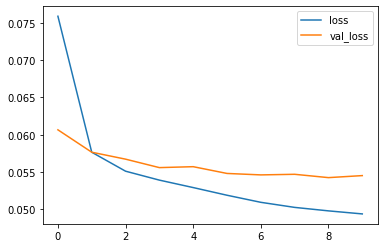

In [23]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

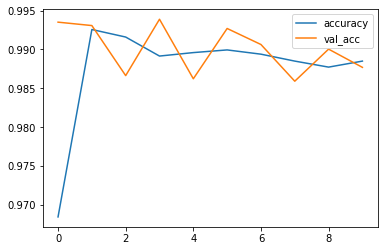

In [24]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show();

In [25]:
p = model.predict(data)
aucs = []
del i
for i in range(5):
  auc = roc_auc_score(targets[:,i], p[:,i])
  aucs.append(auc)
print(np.mean(aucs)) # with cnn 0.9718710715825385

0.977325749567729


In [31]:
def single_predict(sentence):
  single_sequences = tokenizer.texts_to_sequences(sentence)
  pad_input=[[j for i in single_sequences for j in i]]
  single_data = pad_sequences(pad_input, maxlen=MAX_SEQ_LENGTH)
  
  p = model.predict(single_data)
  p = list(p)
  
  # print(ans)
  print(p)
  for i in p[0]:
    print(max([i]))
  print('->',max(p[0]))
single_predict("very good")

[array([0.614254  , 0.00991625, 0.13895458, 0.01076177, 0.24343425,
       0.02223596], dtype=float32)]
0.614254
0.009916246
0.13895458
0.010761768
0.24343425
0.02223596
-> 0.614254


In [33]:
def single_predict(sentence):
    single_sequences = tokenizer.texts_to_sequences(sentence)
    single_data = pad_sequences(single_sequences, maxlen=MAX_SEQ_LENGTH)
    p = model.predict(single_data)[-1]
    lab = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    p = [i for i in p]
    ans = lab[p.index(max(p))] if max(p) > 0.057 else "Neutral"
    print(ans)
    print(p)
single_predict("i am a bad boy")

toxic
[0.058471113, 0.008530855, 0.042796314, 0.0026480258, 0.015029639, 0.0040159523]


In [42]:
single_sequences = tokenizer.texts_to_sequences("worst behaviour")
single_data = pad_sequences(single_sequences, maxlen=MAX_SEQ_LENGTH)
p = model.predict(single_data)
print(p)

[[0.06282893 0.00909188 0.04507411 0.00335598 0.0151796  0.00425032]
 [0.06785446 0.00655967 0.04867917 0.00360382 0.02163118 0.00426349]
 [0.06020197 0.00880301 0.04335311 0.00326332 0.01469776 0.00394624]
 [0.06087101 0.00894237 0.04409263 0.00326809 0.01486641 0.00395572]
 [0.06021097 0.00842941 0.04274184 0.00319669 0.01423675 0.00366986]
 [0.0592339  0.00892904 0.04411271 0.00342357 0.01538831 0.00414222]
 [0.06197032 0.00905901 0.04468906 0.00324368 0.01515409 0.00399354]
 [0.05043161 0.00255609 0.02350706 0.00175557 0.00680116 0.00082347]
 [0.06085867 0.00894108 0.04408553 0.00326866 0.01486325 0.00395525]
 [0.14744139 0.00805175 0.06222677 0.00227204 0.0456987  0.00288519]
 [0.05795163 0.00843519 0.04254338 0.00318387 0.01441813 0.00387806]
 [0.04467952 0.00112566 0.01478672 0.00089061 0.00621575 0.00041583]
 [0.06785443 0.00655964 0.0486792  0.00360379 0.02163118 0.00426349]
 [0.060864   0.00894159 0.04409081 0.00326645 0.01486376 0.00395542]
 [0.06020197 0.00880301 0.04335311

In [45]:
single_sequences = tokenizer.texts_to_sequences("good boy")
single_data = pad_sequences(single_sequences, maxlen=MAX_SEQ_LENGTH)
p = model.predict(single_data)
print(p)

[[0.13954026 0.01519978 0.07296517 0.00630221 0.03049502 0.03451106]
 [0.06785446 0.00655967 0.04867917 0.00360382 0.02163118 0.00426349]
 [0.06785446 0.00655967 0.04867917 0.00360382 0.02163118 0.00426349]
 [0.06366318 0.00486994 0.03652686 0.00144875 0.0161033  0.00197408]
 [0.0592339  0.00892904 0.04411271 0.00342357 0.01538831 0.00414222]
 [0.06197032 0.00905901 0.04468906 0.00324368 0.01515409 0.00399354]
 [0.06785449 0.00655964 0.0486792  0.00360382 0.02163118 0.00426352]
 [0.05847111 0.00853086 0.04279631 0.00264803 0.01502964 0.00401595]]
